# Sentiment Analysis with Hugging Face

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.2 MB/s 

In [ ]:
!pip install accelerate>=0.20.1 transformers

!pip install -U accelerate

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from datasets import load_metric
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import RobertaTokenizer, RobertaModel

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load the train dataset
df = pd.read_csv('/content/drive/MyDrive/Train.csv')

# Eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   9999 non-null   object 
 1   safe_text  9999 non-null   object 
 2   label      9999 non-null   float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [ ]:
df['label'].unique()

array([ 0.,  1., -1.])

In [ ]:
#Loading the test dataset
test = pd.read_csv('/content/drive/MyDrive/Test.csv')

#Check for NaN values
test.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [ ]:
# removing NaN values from test dataset
test = test.dropna()

test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5176 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 121.3+ KB


<Axes: xlabel='label', ylabel='count'>

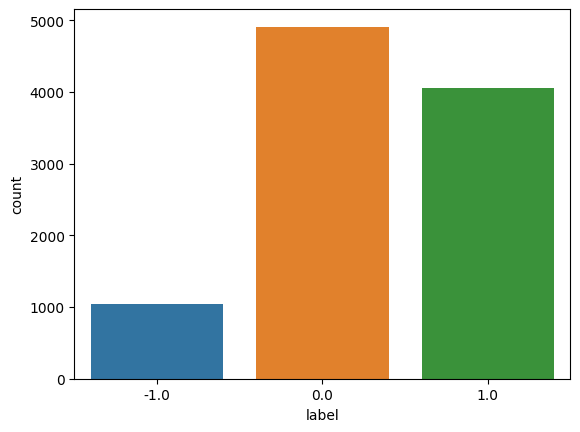

In [ ]:
# visualizing the label column in the train dataset

sns.countplot(x=df['label'])

From the plot above, we can deduce the following.
Close to 50% of the tweets, around 5,000 tweets had Neutral Sentiments. The Positive Sentiment tweets was next with around 4,000 tweets, with the negative tweets being the least.

In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.000000


Examples of Positive Tweets, i.e tweets with Label 1:

In [ ]:
train[train['label'] == 1]['safe_text'].values[:5]

array(["<user>  your ignorance on vaccines isn't just dangerous to your innocent child but to others around you. Shame on you.",
       '<url>\nMom whose child died after catching Chicken Pox advocates for vaccines.',
       'I hope her unvaccinated kid gives Jim Belushi measles. RT <user> <user> what about Jenny McCarthy?',
       'Vaccinate your damn kids. Bc for those kids that cannot get vaccines for real harmful purposes are gonna be just as in danger as kids',
       "hey everyone if you have a kid shoot em up with vaccines. we ain't tryna die of some shit that's preventable ja feel"],
      dtype=object)

Examples of Negative Tweets, i.e tweets with Label -1:

In [ ]:
train[train['label'] == -1]['safe_text'].values[:5]

array(['<user> shld put out a statement "<user> shameful <user> tells FB followers not to worry about measles. <url>',
       '<user> vaccines causes brain swelling, fever, seizures, and ultimately brain damage.  Encephalitis = Autism.  Read package inserts!',
       '<user> #HearThisWell Vaccines r linked 2 autism IBD Peds Note MMR 15 mos #CDCwhistleblower #BreakABillion #B1Less <url>',
       "You couldn't pay me enough to vaccinate my child. No way In hell. #notachance",
       '<user> <user> She has a Son with Autism, when born? Allergies to food? She needs to learn how Vaccines and Glyphosate interact!'],
      dtype=object)

Examples of Neutral Tweets, i.e tweets with Label 0:

In [ ]:
train[train['label'] == 0]['safe_text'].values[:5]

array(["Mickey's Measles has gone international <url>",
       'S1256 [NEW] Extends exemption from charitable immunity for certain civil actions to persons of any age who are be... <url>',
       'Pakistan partly suspends polio vaccination program after terrorists kill health workers\n<url>',
       "In other news I've gone up like 1000 mmr",
       'How vaccines changed the course of US disease over time <url>'],
      dtype=object)

In [ ]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [ ]:
print(f"New DataFrame Shapes: train is {train.shape}, eval is {eval.shape}")

New DataFrame Shapes: train is (7999, 4), eval is (2000, 4)


In [ ]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [ ]:
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
#dataset['train']

In [ ]:
# Configure the training parameters like `num_train_epochs`.

training_args = TrainingArguments("test_trainer", num_train_epochs=3, load_best_model_at_end=True, evaluation_strategy= "steps", save_strategy= 'steps')

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

In [ ]:
# Launch the learning process: training
trainer.train()

Step,Training Loss,Validation Loss
500,0.732900,0.669467
1000,0.646100,0.602234
1500,0.490700,0.679093
2000,0.466700,0.583221
2500,0.293200,0.858013
3000,0.264800,0.859346


TrainOutput(global_step=3000, training_loss=0.4824041798909505, metrics={'train_runtime': 1409.806, 'train_samples_per_second': 17.021, 'train_steps_per_second': 2.128, 'total_flos': 3178876855292928.0, 'train_loss': 0.4824041798909505, 'epoch': 3.0})

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-32-c203b637589b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.5832209587097168,
 'eval_accuracy': 0.763,
 'eval_runtime': 32.8662,
 'eval_samples_per_second': 60.853,
 'eval_steps_per_second': 7.607}

In [ ]:
#trainer.push.hub()

**ROBERTA MODEL**